Using device: cuda

Training Configuration 1: Basic model (1 layer, 4 heads)
Test MSE: 0.004341, MAE: 0.048459
Epoch 01/30 - Train Loss: 0.018027, Test Loss: 0.004341
Test MSE: 0.004341, MAE: 0.051094
Epoch 02/30 - Train Loss: 0.004330, Test Loss: 0.004341
Test MSE: 0.002976, MAE: 0.038740
Epoch 03/30 - Train Loss: 0.003528, Test Loss: 0.002976
Test MSE: 0.003689, MAE: 0.046396
Epoch 04/30 - Train Loss: 0.003170, Test Loss: 0.003689
Test MSE: 0.003198, MAE: 0.041278
Epoch 05/30 - Train Loss: 0.003025, Test Loss: 0.003198
Test MSE: 0.002697, MAE: 0.037717
Epoch 06/30 - Train Loss: 0.002806, Test Loss: 0.002697
Test MSE: 0.003156, MAE: 0.039991
Epoch 07/30 - Train Loss: 0.002695, Test Loss: 0.003156
Test MSE: 0.002459, MAE: 0.034405
Epoch 08/30 - Train Loss: 0.002616, Test Loss: 0.002459
Test MSE: 0.002650, MAE: 0.035497
Epoch 09/30 - Train Loss: 0.002603, Test Loss: 0.002650
Test MSE: 0.002349, MAE: 0.032892
Epoch 10/30 - Train Loss: 0.002516, Test Loss: 0.002349
Test MSE: 0.002252, MAE

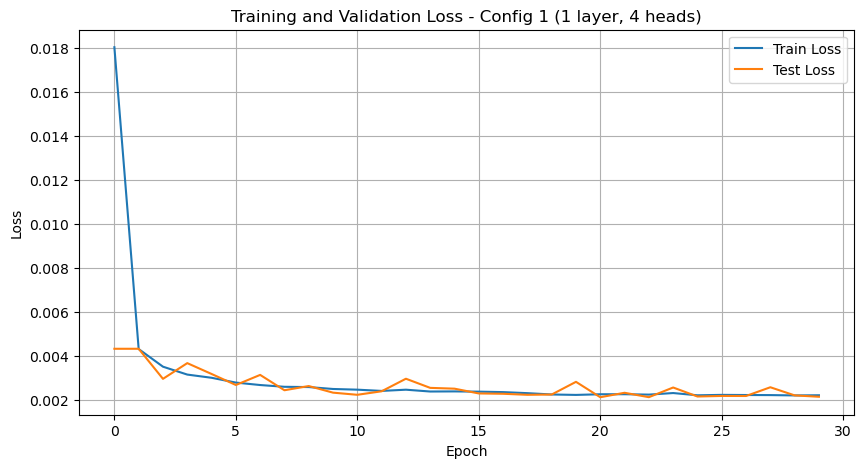


Predictions for all features - Configuration 1


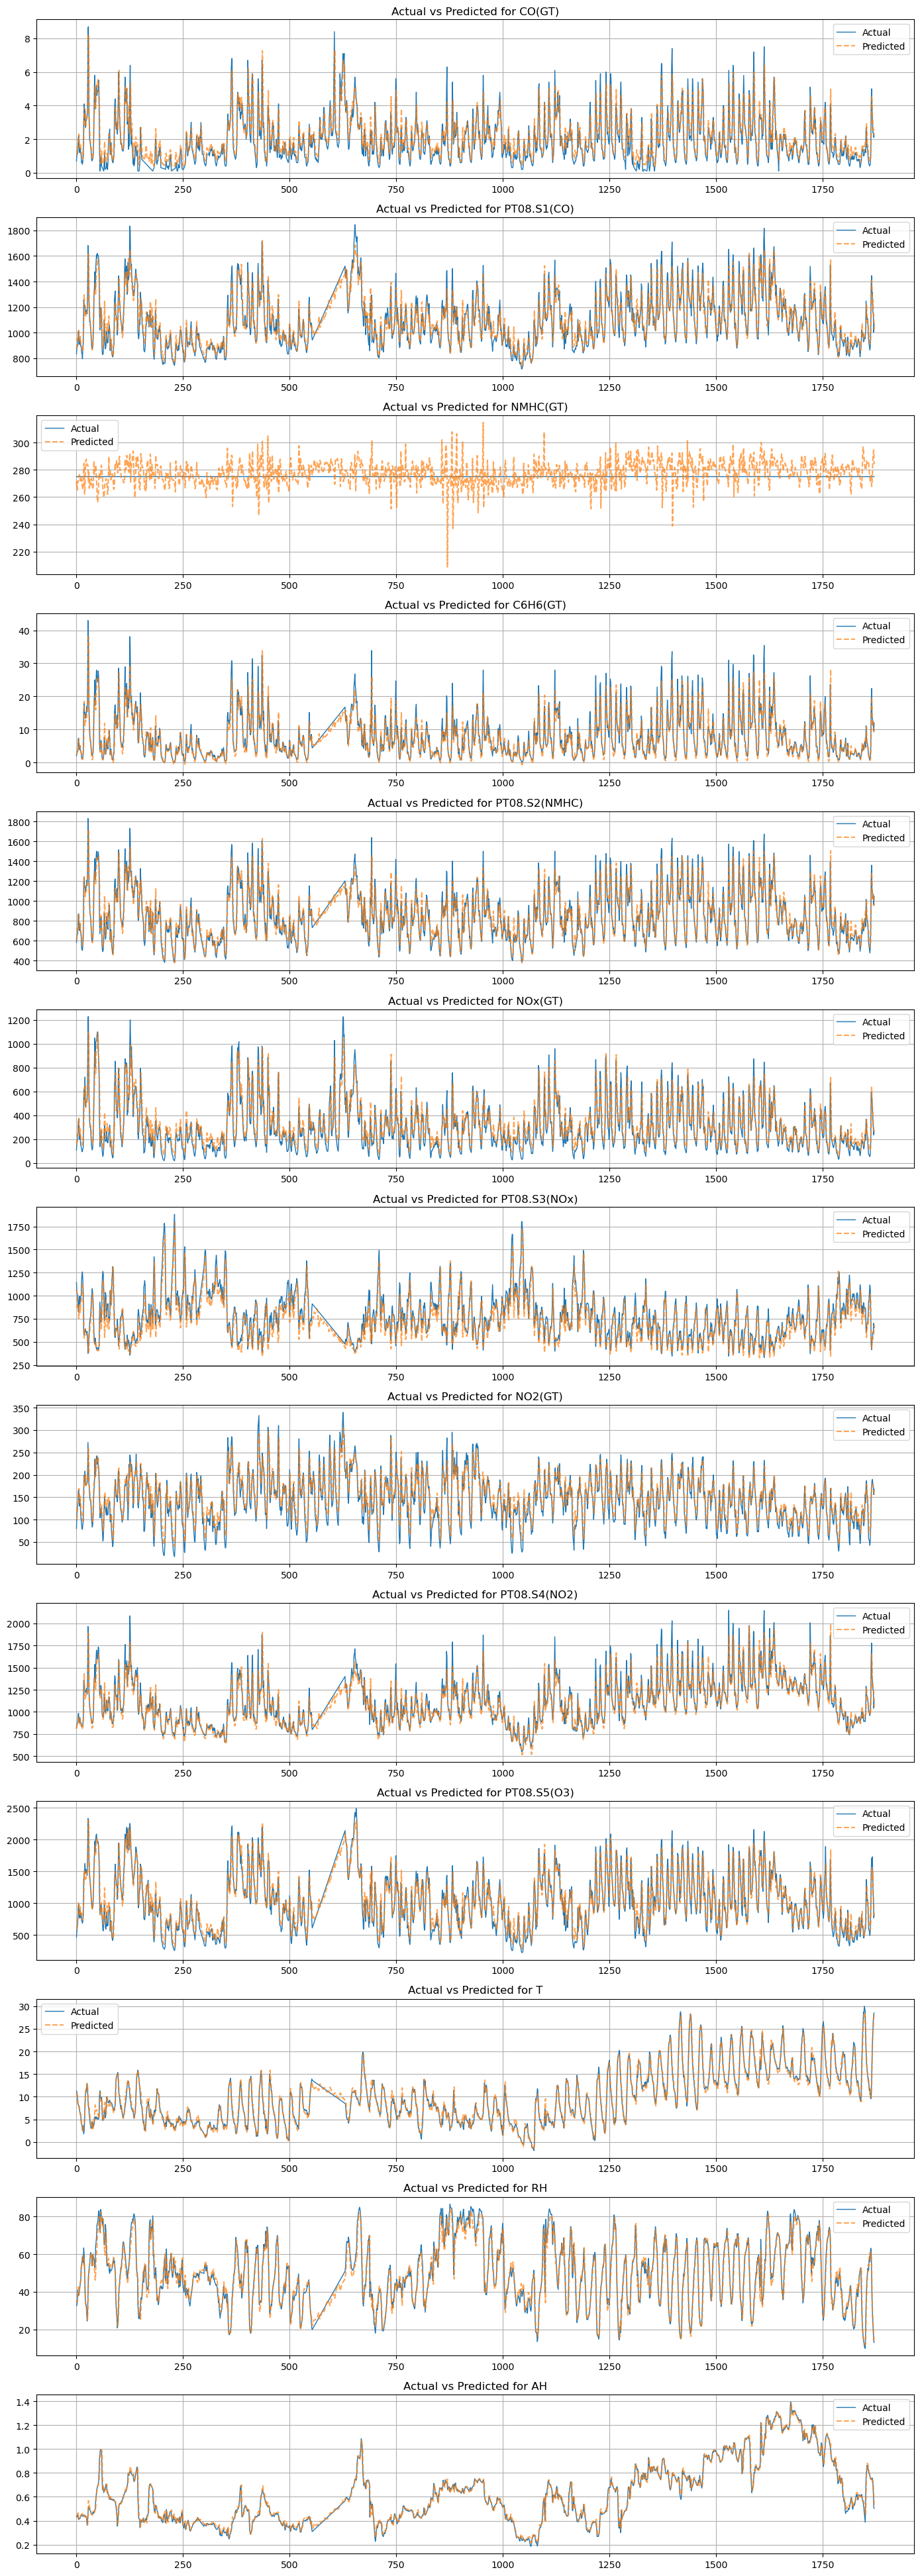

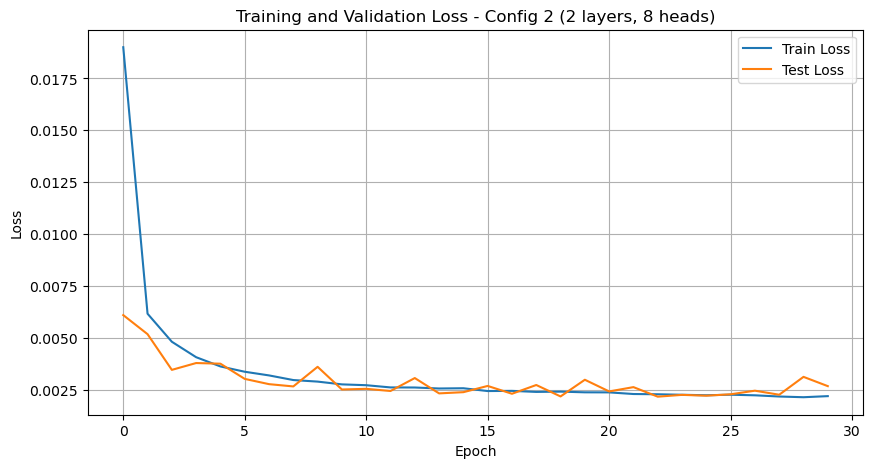


Predictions for all features - Configuration 2


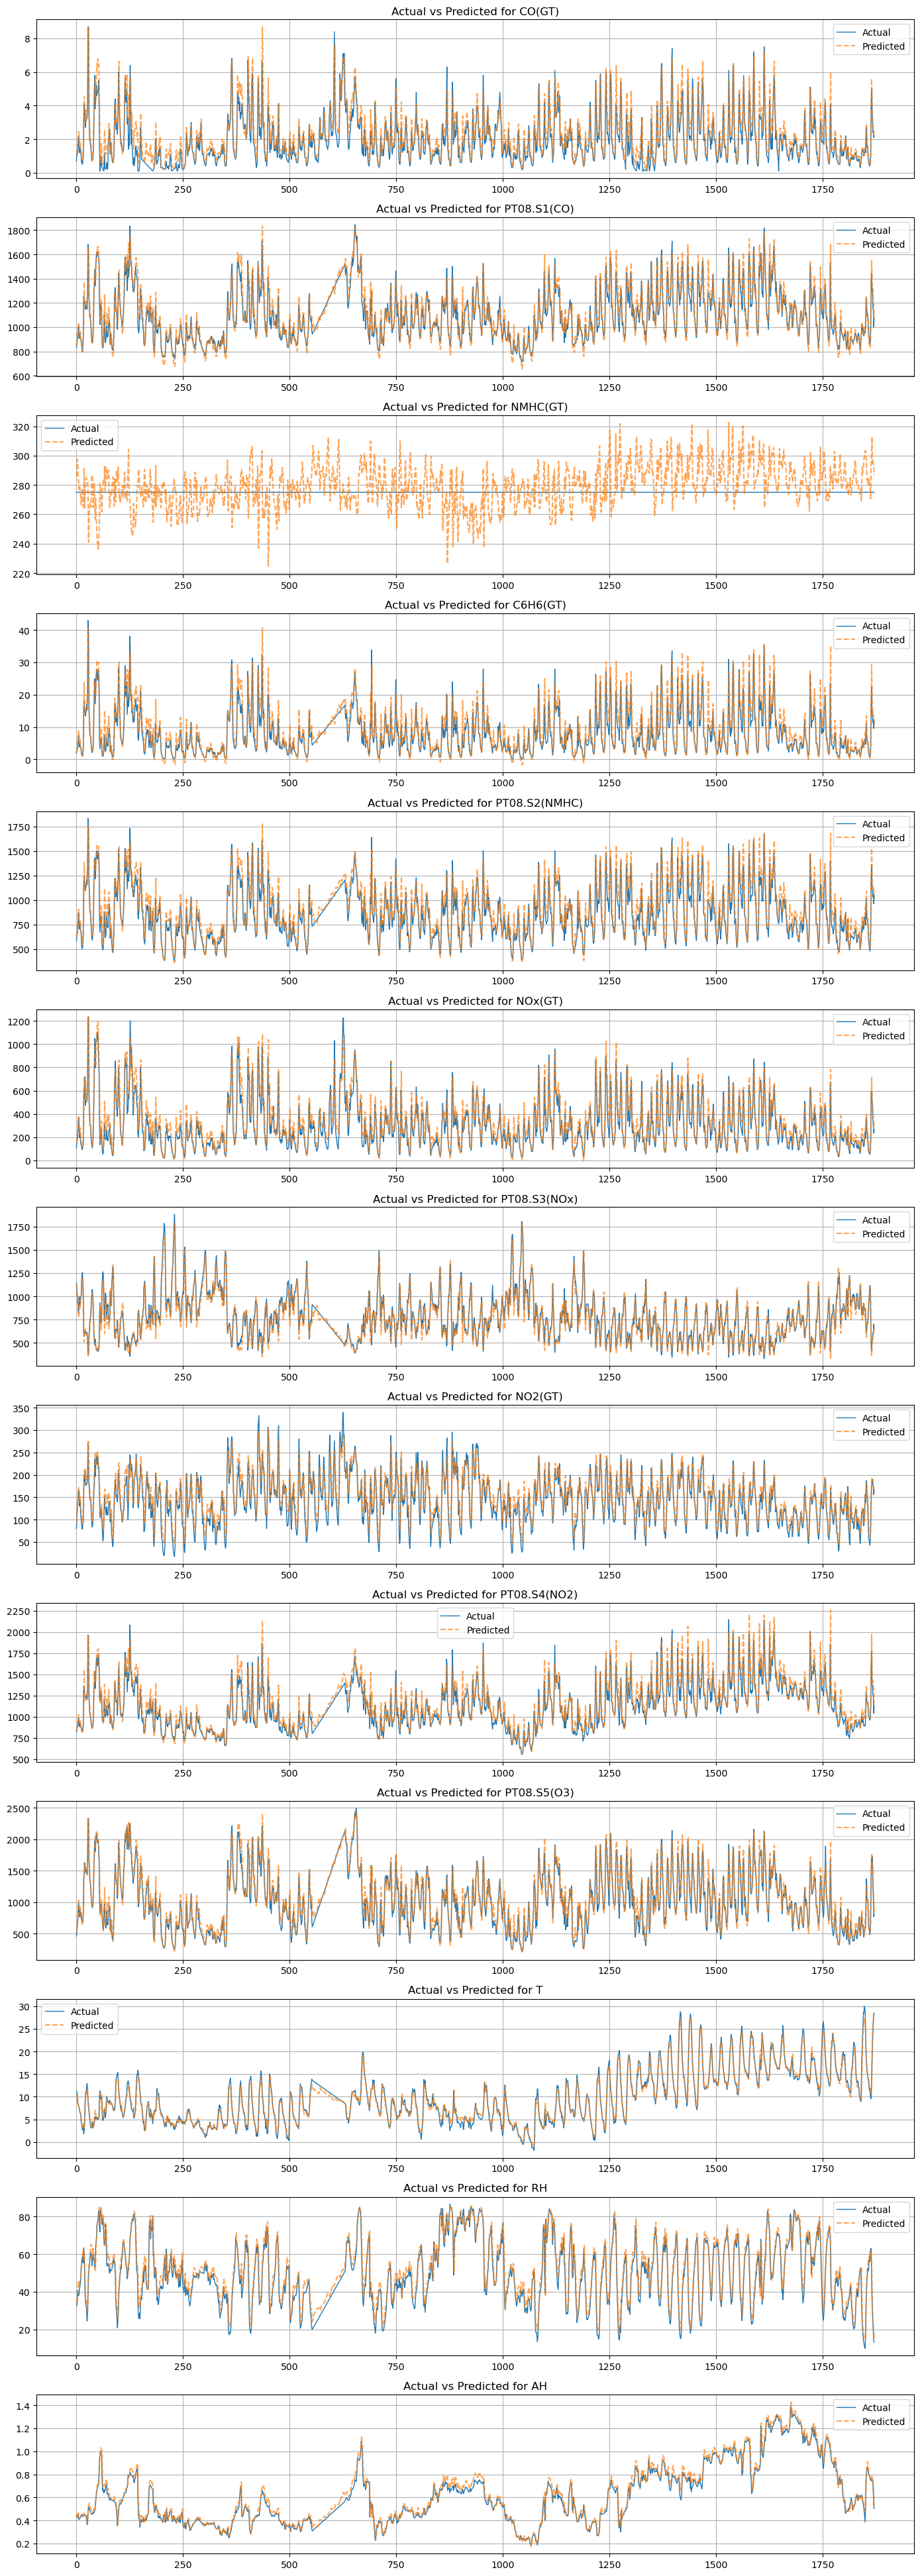

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader

# Set matplotlib to inline mode
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

#Data Loading and Preprocessing

# Check GPU is enabled
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the data
df = pd.read_excel("AirQualityUCI.xlsx")

# Create datetime index
df['Datetime'] = pd.to_datetime(df.iloc[:, 0].astype(str) + ' ' + df.iloc[:, 1].astype(str))
df.set_index('Datetime', inplace=True)

# Select relevant columns (remove non-numeric or all-null columns)
df = df.iloc[:, 2:15]
df = df.dropna(axis=1, how='all')

# Handle missing values 
df = df.replace(-200, np.nan)
df = df.interpolate(method='time')  # time-based interpolation

# Normalize the data
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[df.columns] = scaler.fit_transform(df[df.columns])

#Prepare Sequences for Time Series Forecasting

#  only the normalized numeric columns is selected
numeric_cols = df_norm.select_dtypes(include='number').columns.tolist()
data = df_norm[numeric_cols].values.astype(np.float32)  # shape (T, F)

seq_len = 24  # using 24 hours of history to predict next hour
n_features = data.shape[1]

# 80/20 train/test split, with overlap so the first test window still has 24 points
train_ratio = 0.8
split_idx = int(len(data) * train_ratio)
train_data = data[:split_idx]
test_data = data[split_idx - seq_len:]

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]  # (seq_len, F)
        y = self.data[idx + self.seq_len]     # (F,)
        return torch.tensor(x), torch.tensor(y)

train_ds = TimeSeriesDataset(train_data, seq_len)
test_ds = TimeSeriesDataset(test_data, seq_len)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

#Transformer Model Definition 

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # x: (B, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=64, n_heads=4, num_layers=1, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, n_features)

    def forward(self, x):
        # x: (B, seq_len, n_features)
        x = self.input_proj(x)       # → (B, seq_len, d_model)
        x = self.pos_enc(x)          # add pos encoding
        x = self.transformer(x)      # → (B, seq_len, d_model)
        x = x[:, -1, :]              # take last time-step → (B, d_model)
        out = self.fc_out(x)         # → (B, n_features)
        return out

#Training and Evaluation

def train_model(model, train_loader, test_loader, optimizer, criterion, n_epochs, device):
    train_losses = []
    test_losses = []
    
    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0.0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * xb.size(0)
        
        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # Evaluate on test set
        test_loss = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        
        print(f"Epoch {epoch:02d}/{n_epochs} - Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}")
    
    return train_losses, test_losses

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item() * xb.size(0)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Calculate additional metrics
    mse = mean_squared_error(all_targets, all_preds)
    mae = mean_absolute_error(all_targets, all_preds)
    print(f"Test MSE: {mse:.6f}, MAE: {mae:.6f}")
    
    return avg_loss

def plot_loss_curves(train_losses, test_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_all_predictions(model, test_loader, scaler):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    # Create a figure with subplots for each feature
    n_features = all_preds.shape[1]
    fig, axes = plt.subplots(n_features, 1, figsize=(14, 3*n_features))
    
    if n_features == 1:
        axes = [axes]  # Ensure axes is always a list
    
    for i, (ax, feature_name) in enumerate(zip(axes, df.columns)):
        # Inverse transform for this specific feature
        dummy_data = np.zeros((len(all_preds), len(scaler.feature_names_in_)))
        dummy_data[:, i] = all_preds[:, i]
        preds_unscaled = scaler.inverse_transform(dummy_data)[:, i]
        
        dummy_data[:, i] = all_targets[:, i]
        targets_unscaled = scaler.inverse_transform(dummy_data)[:, i]
        
        ax.plot(targets_unscaled, label='Actual', linewidth=1)
        ax.plot(preds_unscaled, label='Predicted', alpha=0.7, linestyle='--')
        ax.set_title(f'Actual vs Predicted for {feature_name}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

#Experiment with Different Configurations

# Configuration 1: Basic model
print("\nTraining Configuration 1: Basic model (1 layer, 4 heads)")
model1 = TransformerRegressor(n_features, d_model=64, n_heads=4, num_layers=1).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_losses1, test_losses1 = train_model(
    model1, train_loader, test_loader, optimizer1, criterion, n_epochs=30, device=device
)


# Configuration 2: changed model
print("\nTraining Configuration 2: changed model (2 layer, 8 heads)")
model2 = TransformerRegressor(n_features, d_model=64, n_heads=8, num_layers=2).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=3e-4)
criterion = nn.MSELoss()

train_losses2, test_losses2 = train_model(
    model2, train_loader, test_loader, optimizer2, criterion, n_epochs=30, device=device
)


# Plot for configuration 1
plot_loss_curves(train_losses1, test_losses1, "Config 1 (1 layer, 4 heads)")
print("\nPredictions for all features - Configuration 1")
plot_all_predictions(model1, test_loader, scaler)

# Plot for configuration 2
plot_loss_curves(train_losses2, test_losses2, "Config 2 (2 layers, 8 heads)")
print("\nPredictions for all features - Configuration 2")
plot_all_predictions(model2, test_loader, scaler)